**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# **Importing all the important libraries**

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# **Importing Skin Cancer Data**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# **Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

# **Create a dataset**

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# **Visualize the data**

**Todo, create a code to visualize one instance of all the nine classes present in the dataset**

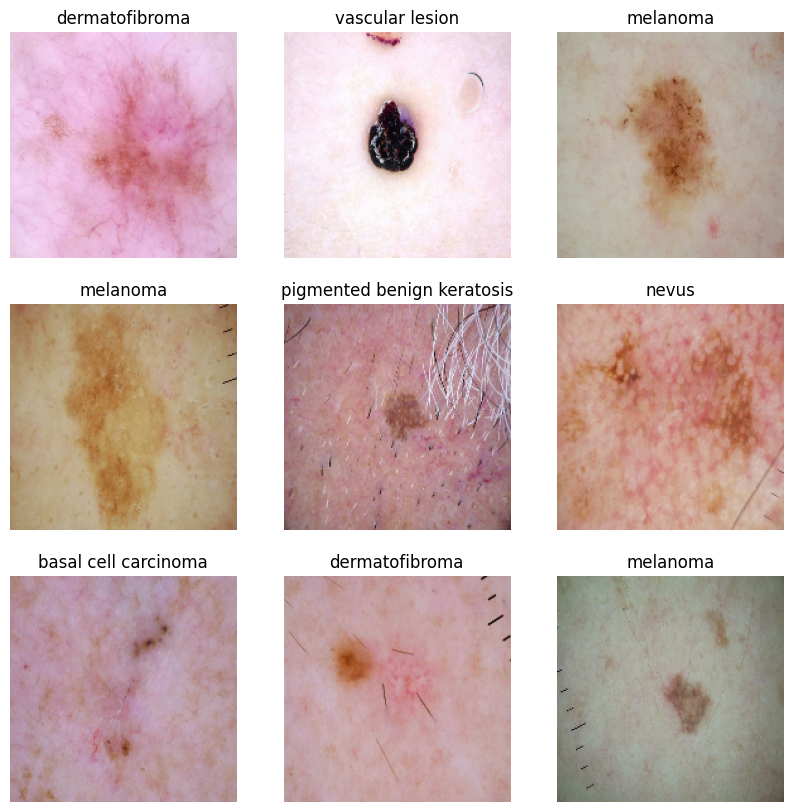

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

 The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [ ]:
#One hot encode the Label of Class
def one_hot_label(image, label):
    label = tf.one_hot(label, 9)
    return image, label


In [ ]:
train_ds = train_ds.map(one_hot_label, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
val_ds = val_ds.map(one_hot_label, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Create the model**

**Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]**

In [ ]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [ ]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

#Apply filter to input image to produce transformed feature map
#Each Convolutional Layer detect patterns of a specific feature type
# A ReLU (Rectified Linear Unit) activation function introductes non-linearity
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))

#From each 2x2 window applying on original grid, pick largest number
#Useful for Feature selection, Spatial dimension reduction
#and helps reduce overfitting
#Also speeds up the training process
model.add(MaxPool2D(pool_size=(2, 2)))

#Slide 64 filters across image and create 64 feature maps to
#understand various aspects of image
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

#Makes training smoother & faster for better performance
#Ensures network works well under various image conditions
model.add(BatchNormalization())

#Makes feature detection invariant to changes/distortions
model.add(MaxPool2D(pool_size=(2, 2)))

#Slide 128 filters across image and create 128 feature maps to
#understand various aspects of image
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

#Convert multi-dimensional output of previous layers into 1-D array
model.add(Flatten())

#Fully connected layer with 512 neurons
model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))

#Dropout prevents overfitting by randomly setting 50% of inputs to zero
model.add(Dropout(0.5))

## Number of classes is 9
model.add(Dense(9, activation='softmax'))

#**Compile the model**

Choose an appropirate optimiser and loss function for model training

In [ ]:
### Choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrap  (None, 178, 178, 32)      896       
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 176, 176, 32)      9248      
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 88, 88, 32)        0         
 apper)                                                          
                                                                 
 module_wrapper_3 (ModuleWr  (None, 86, 86, 64)        18496     
 apper)                                                 

# **Train the model**

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  steps_per_epoch=len(train_ds),
  validation_steps=len(val_ds)
)

Epoch 1/20
169/169 [==============================] - 919s 1s/step - loss: 21.2313 - accuracy: 0.3116 - val_loss: 12.1946 - val_accuracy: 0.1559
Epoch 2/20
169/169 [==============================] - 11s 67ms/step - loss: 2.6804 - accuracy: 0.3759 - val_loss: 4.4699 - val_accuracy: 0.1269
Epoch 3/20
169/169 [==============================] - 11s 68ms/step - loss: 1.5204 - accuracy: 0.4570 - val_loss: 12.6478 - val_accuracy: 0.1566
Epoch 4/20
169/169 [==============================] - 11s 66ms/step - loss: 1.3809 - accuracy: 0.5206 - val_loss: 5.0462 - val_accuracy: 0.2494
Epoch 5/20
169/169 [==============================] - 11s 66ms/step - loss: 1.2211 - accuracy: 0.5601 - val_loss: 1.3446 - val_accuracy: 0.5947
Epoch 6/20
169/169 [==============================] - 11s 67ms/step - loss: 1.1241 - accuracy: 0.6053 - val_loss: 1.4146 - val_accuracy: 0.5575
Epoch 7/20
169/169 [==============================] - 12s 70ms/step - loss: 1.0494 - accuracy: 0.6335 - val_loss: 2.7359 - val_accurac

# **Visualizing the results**

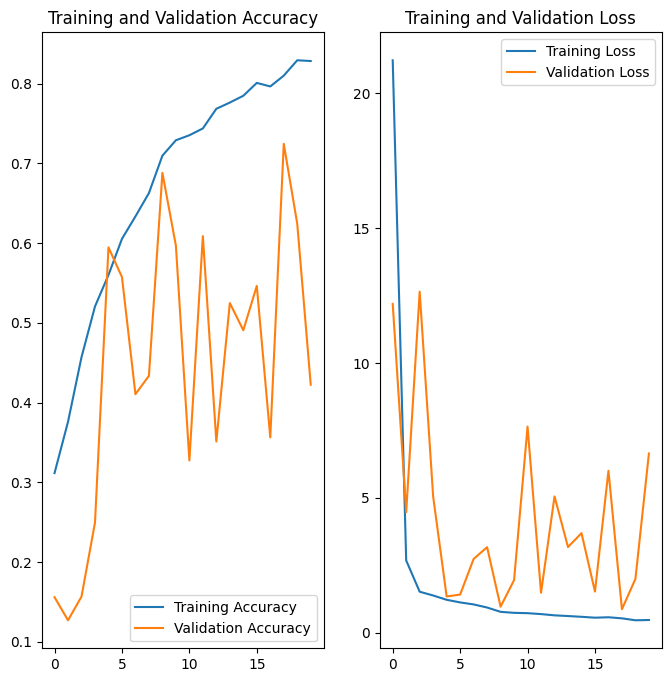

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Model Overfit or Underfit?**

# **Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?**

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)



169/169 [==============================] - 3s 16ms/step - loss: 6.0078 - accuracy: 0.4559


In [ ]:
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


# Thus we can clearly that model Overfit and we need to chose right data augumentation strategy

43/43 [==============================] - 1s 18ms/step - loss: 6.6464 - accuracy: 0.4224
Accuracy:  0.45586052536964417
Validation Accuracy:  0.4224202036857605
Loss:  6.007846355438232
Validation Loss 6.646392822265625


##Findings
##1) The model seems to be overfitting, as there is a significant gap between training accuracy and validation accuracy.
##2) The model performs well on the training data but fails to generalize on the validation data.

# **Todo: Find the distribution of classes in the training dataset.**

**Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.**

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 2390 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


## **Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit**

## **Write your findings here**

**Observation:**From the above model we can clearly see that our model is getting overfitted.

**So, We will use the layer strartegy because it dosen't require any changes to original dataset.**

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2,fill_mode="reflect"),
])

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 40))
for images, labels in list(train_ds.take(1)):
  augmented_image = data_augmentation(images)
  j=1
  for i in range(9):
    ax = plt.subplot(9, 2, j)
    plt.imshow(augmented_image[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    j+=1

    ax = plt.subplot(9, 2, j)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    j+=1

  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

<Figure size 1000x1000 with 0 Axes>

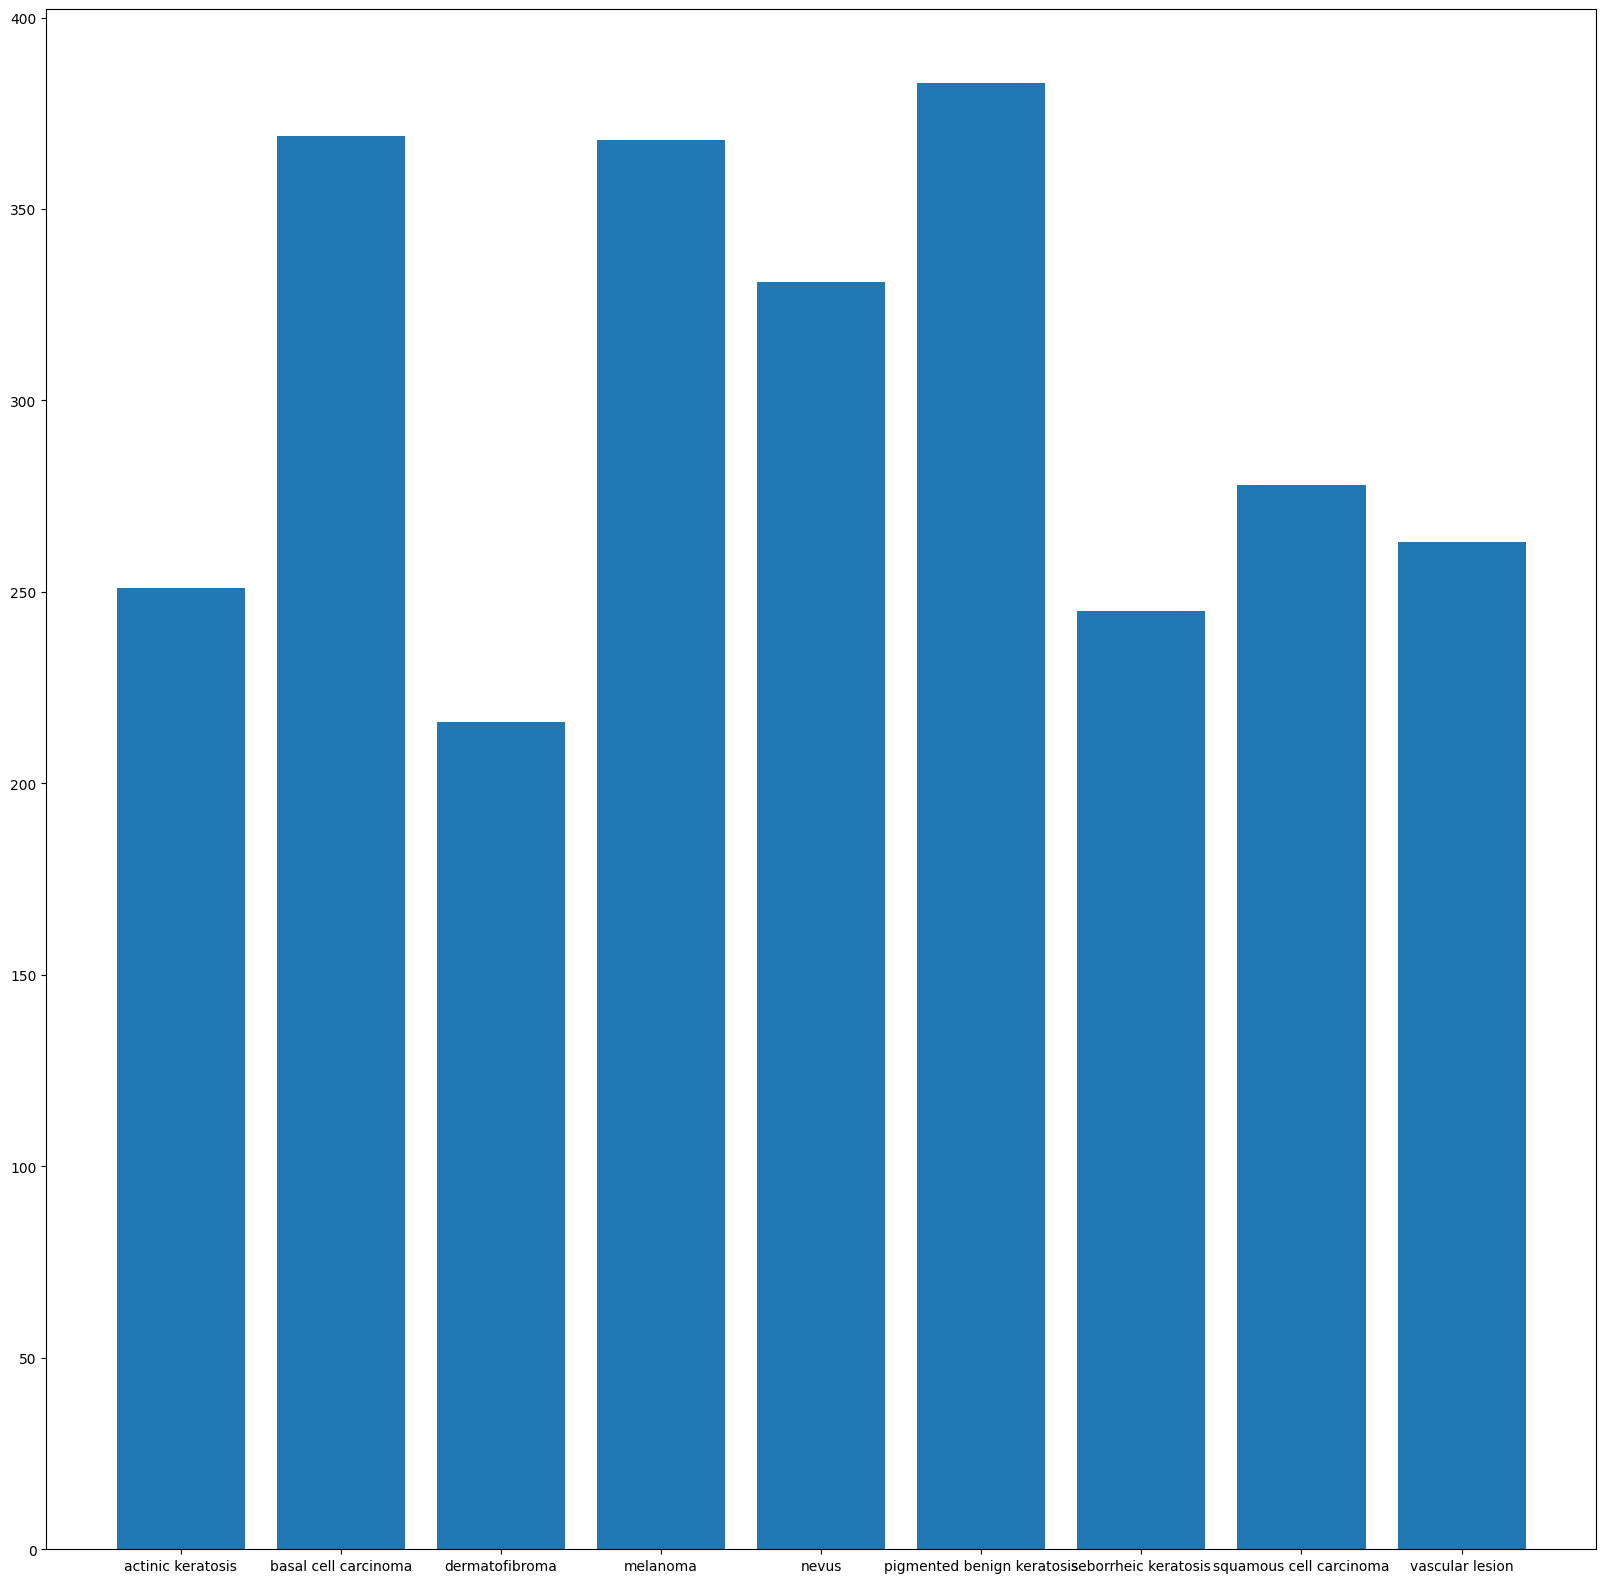

In [ ]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))

batch_size = images.shape[0]

for images, labels in train_ds:
  for i in range(batch_size):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i])

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

# **Todo: Write your findings here:**

### **- Which class has the least number of samples?**

### **- Which classes dominate the data in terms proportionate number of samples?**

## **Findings**
### 1) The class "actinic keratosis" has the least number of samples.

### 2) The classes "pigmented benign keratosis" and "nevus" dominate the data
### in terms of proportionate number of samples, with "pigmented benign keratosis" having the highest number.

# **Todo: Rectify the class imbalance**

## **Todo:Rectify the class imbalance Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.**

In [ ]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [ ]:
path_to_training_dataset="gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x780C71868070>: 100%|██████████| 500/500 [00:23<00:00, 21.35 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x780C71885B40>: 100%|██████████| 500/500 [00:23<00:00, 21.61 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x780C71868070>: 100%|██████████| 500/500 [00:21<00:00, 23.46 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x780C71BDE020>: 100%|██████████| 500/500 [01:23<00:00,  5.96 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x780C71BC4B20>: 100%|██████████| 500/500 [01:12<00:00,  6.90 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x780C71868190>: 100%|██████████| 500/500 [00:19<00:00, 26.00 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x780C71B061D0>: 100%|██████████| 500/500 [00:37<00:00, 13.48 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x780C717FC5E0>: 100%|██████████| 500/500 [00:18<00:00, 27.69 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x780C71885B40>: 100%|██████████| 500/500 [00:17<00:00, 28.44 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027047.jpg_4616ccf1-d8eb-46e3-bc23-ba4ea941c681.jpg',
 'gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026522.jpg_04466acb-92c3-499b-83de-5956db811f42.jpg',
 'gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0033869.jpg_8f50f55c-2ef3-465a-b645-64ef6e024f55.jpg',
 'gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032329.jpg_8057eb69-cfa2-406b-b676-7110d814ec8b.jpg',
 'gdrive/My Drive/Colab Notebooks/CN

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
new_df = df2

In [ ]:
new_df['Label'].value_counts()

squamous cell carcinoma       1000
actinic keratosis             1000
pigmented benign keratosis    1000
dermatofibroma                1000
vascular lesion               1000
melanoma                      1000
basal cell carcinoma          1000
nevus                         1000
seborrheic keratosis          1000
Name: Label, dtype: int64

Added 500 images to all the classes to maintain some class .

# **Todo: Train the model on the data created using Augmentor**

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

# **Todo: Create a training dataset**

In [ ]:
data_dir_train="gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


# **Todo: Create a validation dataset**

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [ ]:
train_ds = train_ds.map(one_hot_label, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Todo: Create your model (make sure to include normalization)**

In [ ]:
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

## Number of classes is 9
model.add(Dense(9, activation='softmax'))

# **Todo: Compile your model (Choose optimizer and loss function appropriately)**

In [ ]:
optimizer =  tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

# **Todo: Train your model**

In [ ]:
epochs = 30

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/30
281/281 [==============================] - 111s 175ms/step - loss: 1.8091 - accuracy: 0.3842 - val_loss: 2.0094 - val_accuracy: 0.3605 - lr: 0.0010
Epoch 2/30
281/281 [==============================] - 33s 117ms/step - loss: 1.3548 - accuracy: 0.5145 - val_loss: 1.3780 - val_accuracy: 0.5105 - lr: 0.0010
Epoch 3/30
281/281 [==============================] - 33s 116ms/step - loss: 1.1054 - accuracy: 0.5971 - val_loss: 3.6409 - val_accuracy: 0.2203 - lr: 0.0010
Epoch 4/30
281/281 [==============================] - 33s 116ms/step - loss: 0.9778 - accuracy: 0.6459 - val_loss: 1.2308 - val_accuracy: 0.5616 - lr: 0.0010
Epoch 5/30
281/281 [==============================] - 33s 116ms/step - loss: 0.8091 - accuracy: 0.7087 - val_loss: 1.0237 - val_accuracy: 0.6346 - lr: 0.0010
Epoch 6/30
281/281 [==============================] - 33s 116ms/step - loss: 0.6835 - accuracy: 0.7543 - val_loss: 0.7582 - val_accuracy: 0.7254 - lr: 0.0010
Epoch 7/30
281/281 [==============================]

# **Todo: Visualize the model results**

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?**

## **Analysis:**

1. The model's performance on the training data is very good with an accuracy of 96.96%.
2. The validation accuracy of 90.92% indicates that the model is also performing well on unseen data, although there's a gap between training and validation accuracy (~6%).
3. Overfitting: There are few signs of overfitting since the training accuracy keeps rising, but the validation accuracy varies.
4. Underfitting: The model doesn't show signs of underfitting since the training accuracy and loss are moving in the expected directions (accuracy increasing and loss decreasing).
5. The class rebalance helped reduce the overfititng of the data.
6. Employing more data augmentation, dropout, or regularization may further reduce the overfitting.